# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
2. View the SST data and spatial and temporal gradients
3. Perform Gaussian Process regression and inspect the hyper-parameter results
4. View the surface current predictions and uncertainties

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plots
from inversion_sst_gp import gp_regression as gpr
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

%matplotlib inline

/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Download himawari data

##### Set geographical limits and chose a time step

*Note that ~3 x 3 degree boxes are a recommended maximum area for reasonable processing on personal computers.*

In [2]:
# Define geographical and temporal boundaries for data processing
LON_LIMITS = (145.5, 147)
LAT_LIMITS = (24.5, 26)  
ll_box = (LON_LIMITS, LAT_LIMITS)

# Set the time bounds - predictions will be done hourly within these limits
time_lims = ["2025-05-12T00:00:00", "2025-05-13T00:00:00"]

# Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
data_dir = os.path.join('../', '../', '1_preproc_data', 'non_proc_data', 'himawari', 'himawari_tutorial_01')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

##### Retrieve the required complete Himawari data files

By default this function will not overwrite existing files of the same name. 

This cell only needs to be run once. 

In [3]:
# # Download the data
# himawari.get_sst_series_nasa(time_lims, data_dir)

In [4]:
# Crop himawari files (optional)
crop_app = 'test_project1'

# Setting ow=True will delete the original files after cropping (can also just set file_app='')
himawari.crop_sst_series_nasa(data_dir, time_lims, ll_box, file_app=crop_app, ow=True)

Overwrite set to True: original files will be deleted!
File does not exist: ../../1_preproc_data/non_proc_data/himawari/himawari_tutorial_01/20250511230000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
File does not exist: ../../1_preproc_data/non_proc_data/himawari/himawari_tutorial_01/20250512000000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
File does not exist: ../../1_preproc_data/non_proc_data/himawari/himawari_tutorial_01/20250512010000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
File does not exist: ../../1_preproc_data/non_proc_data/himawari/himawari_tutorial_01/20250512020000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
File does not exist: ../../1_preproc_data/non_proc_data/himawari/himawari_tutorial_01/20250512030000-STAR-L3C_GHRSST-SSTsubskin-AHI_H09-ACSPO_V2.90-v02.0-fv01.0.nc
File does not exist: ../../1_preproc_data/non_proc_data/himawari/himawari_tutorial_01/20250512040000-STAR-L3C_GHRSST-SSTsubsk

In [5]:
# Load the data
ds = himawari.process_sst_series(data_dir, time_lims, ll_box, file_app=crop_app)
ds

<xarray.Dataset> Size: 502kB
Dimensions:    (time: 24, lat: 25, lon: 25)
Coordinates:
  * time       (time) <U19 2kB '2025-05-12T00:00:00' ... '2025-05-12T23:00:00'
  * lat        (lat) float64 200B 24.53 24.59 24.65 24.71 ... 25.85 25.91 25.97
  * lon        (lon) float64 200B 145.5 145.6 145.7 145.7 ... 146.8 146.9 147.0
    LON        (lat, lon) float64 5kB 145.5 145.6 145.7 ... 146.8 146.9 147.0
    LAT        (lat, lon) float64 5kB 24.53 24.53 24.53 ... 25.97 25.97 25.97
    X          (lat, lon) float64 5kB -7.296e+04 -6.688e+04 ... 7.21e+04
    Y          (lat, lon) float64 5kB -7.976e+04 -7.976e+04 ... 7.976e+04
    lonc       float64 8B 146.2
    latc       float64 8B 25.25
    time_step  int64 8B 3600
Data variables:
    T          (time, lat, lon) float64 120kB 27.34 26.98 nan ... 25.92 25.95
    dTdt       (time, lat, lon) float64 120kB 2.947e-05 5.401e-05 ... 7.068e-05
    dTdx       (time, lat, lon) float64 120kB -5.918e-05 ... 4.624e-06
    dTdy       (time, lat, lon) float64 120kB -3.678e-05 nan ... -2.173e-05

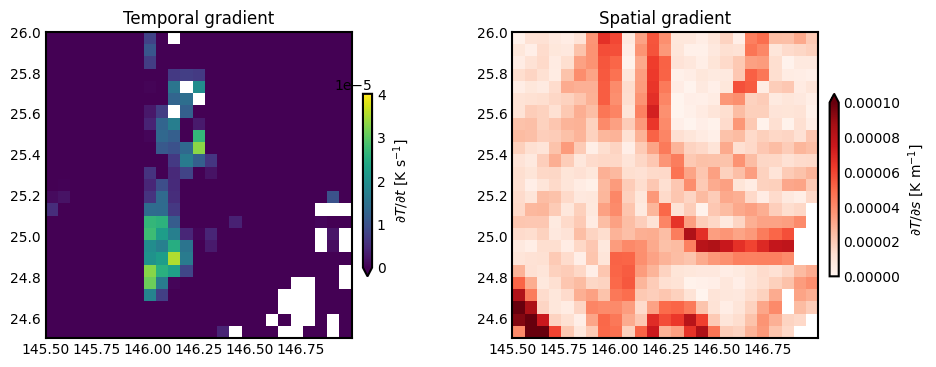

In [6]:
fig, ax = plots.plot_gradients(ds.isel(time=14), sg_names=['dTdx','dTdy'])

# Using the de Kreij code to make a GP prediction

Adapted from this example:
https://github.com/rdkreij/inversion-sst-gp/blob/main/4_satellite_application/4_1_case_1_rossby_number.py

In [7]:
guess_params = {
    "sigma_u": 9e-2,
    "l_u": 3e4,
    "tau_u": 1e-2,
    "sigma_v": 9e-2,
    "l_v": 3e4,
    "tau_v": 1e-2,
    "sigma_S": 3e-7,
    "l_S": 2e4,
    "tau_S": 2e-7,
    "sigma_tau": 1e-2,
}

print("Calculating GP regression prediction")
ds = gpr.predict_series(ds, guess_params)

Calculating GP regression prediction


/mnt/c/Users/00099894/OneDrive - The University of Western Australia/UWA/Inpex/pl/pckgs/inversion-sst-gp/pkg/inversion_sst_gp/gp_regression.py:660: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):


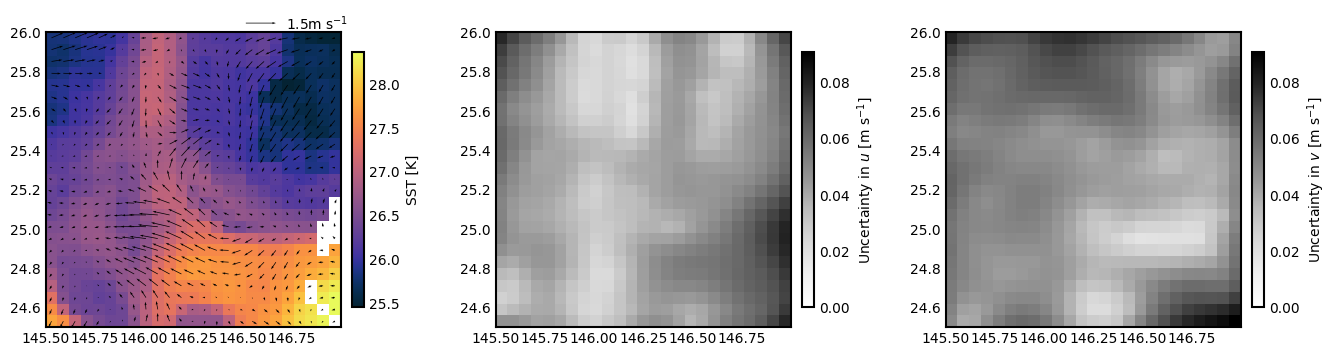

In [8]:
# Plot the mean estimation
fig, ax = plots.plot_prediction(ds.isel(time=14), qk_size=1.5)

---
# Run the parameter optimization

##### Running on the first time step only

This is acceptable for short time series where it is expected that the hyper-parameters do not change significantly over time.

In [9]:
# Set model hyperparameters
prop_sat = gpr.get_default_params()

# Run model
print("Running GP optimization")

ds_one = ds.isel(time=0)
results = gpr.run_gprm_optim_xr(ds_one, prop_sat)
results

Running GP optimization
sigma_u       l_u           tau_u         sigma_S       l_S           tau_S         sigma_tau     lml        
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01        

{'step': '2025-05-12T00:00:00',
 'est_params': {'sigma_u': np.float64(0.19284197780159618),
  'l_u': np.float64(13048.483392587656),
  'tau_u': np.float64(0.010024114364856791),
  'sigma_S': np.float64(1.2245061434535165e-05),
  'l_S': np.float64(17927.80317546584),
  'tau_S': np.float64(6.163925546338405e-07),
  'sigma_tau': np.float64(0.01142253249847384),
  'l_v': np.float64(13048.483392587656),
  'sigma_v': np.float64(0.19284197780159618),
  'tau_v': np.float64(0.010024114364856791)}}

In [10]:
results_step = []
for t in range(ds.dims['time']):
    print(f"Optimizing time step {t+1} of {ds.dims['time']}")
    ds_t = ds.isel(time=t)
    res_t = gpr.run_gprm_optim_xr(ds_t, prop_sat)
    results_step.append(res_t)

Optimizing time step 1 of 24
sigma_u       l_u           tau_u         sigma_S       l_S           tau_S         sigma_tau     lml        


/tmp/ipykernel_12255/1838215335.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):
/tmp/ipykernel_12255/1838215335.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Optimizing time step {t+1} of {ds.dims['time']}")


0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          2146.0     
10.0          1.0           1.0           0.001         1e+06         0.001         1.0           -6.5036e+05
10.0      

In [ ]:
# Convert to a pandas DataFrame
import pandas as pd

step_strs = [rs['step'] for rs in results_step]
step_res = [rs['est_params'] for rs in results_step]
df = pd.DataFrame(step_res)
df['time'] = pd.Series(step_strs)

# Convert 'step' to a datetime object
df['time'] = pd.to_datetime(df['time'])

# Convert to xarray.Dataset
ds = xr.Dataset.from_dataframe(df.set_index('time'))

# Save to NetCDF
ds.to_netcdf(path=os.path.join(data_dir, f'gpr_example2_fits.nc'))

In [23]:
_=[print(f'sigma_u = {res_t["est_params"]["sigma_u"]:.3f}') for res_t in results_step]

sigma_u = 0.193
sigma_u = 0.188
sigma_u = 0.200
sigma_u = 0.198
sigma_u = 0.178
sigma_u = 0.167
sigma_u = 0.159
sigma_u = 0.159
sigma_u = 0.173
sigma_u = 0.180
sigma_u = 0.170
sigma_u = 0.158
sigma_u = 0.185
sigma_u = 0.182
sigma_u = 0.194
sigma_u = 0.197
sigma_u = 0.160
sigma_u = 0.171
sigma_u = 0.135
sigma_u = 0.174
sigma_u = 0.141
sigma_u = 0.159
sigma_u = 0.175
sigma_u = 0.188


In [21]:
_=[print(f'l_u = {res_t["est_params"]["l_u"]:.0f}') for res_t in results_step]

l_u = 13048
l_u = 11070
l_u = 10648
l_u = 10296
l_u = 9974
l_u = 12615
l_u = 12746
l_u = 14711
l_u = 11056
l_u = 10080
l_u = 8700
l_u = 9388
l_u = 8864
l_u = 9116
l_u = 7830
l_u = 7863
l_u = 8954
l_u = 6255
l_u = 9029
l_u = 7964
l_u = 4806
l_u = 14154
l_u = 10072
l_u = 11921


In [11]:
print("Calculating GP regression prediction")
ds_step = gpr.predict_series(ds, results['est_params'])

Calculating GP regression prediction


/mnt/c/Users/00099894/OneDrive - The University of Western Australia/UWA/Inpex/pl/pckgs/inversion-sst-gp/pkg/inversion_sst_gp/gp_regression.py:660: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims['time']):


In [12]:
print("Calculating GP regression prediction")
ds_all = gpr.predict_series(ds, results_step)

Calculating GP regression prediction


/mnt/c/Users/00099894/OneDrive - The University of Western Australia/UWA/Inpex/pl/pckgs/inversion-sst-gp/pkg/inversion_sst_gp/gp_regression.py:654: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t,p in zip(range(ds.dims['time']), params):


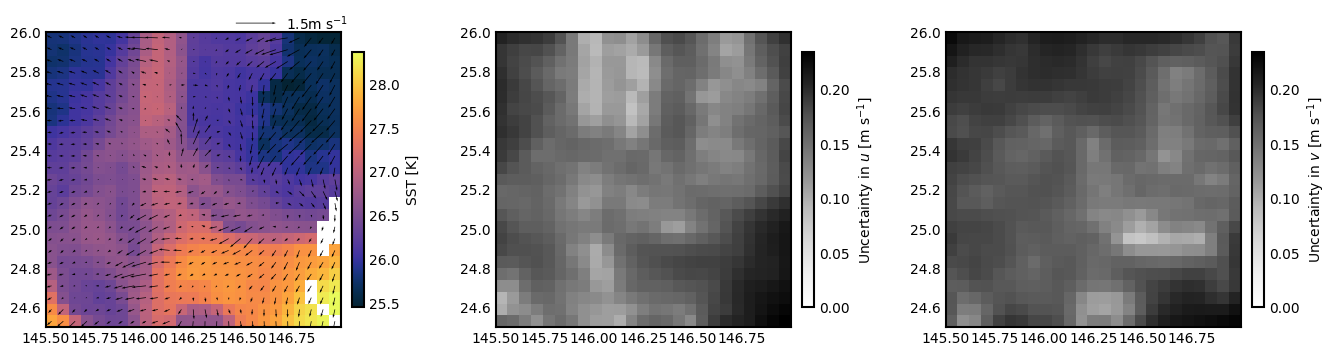

In [13]:
fig, ax = plots.plot_prediction(ds_step.isel(time=14), qk_size=1.5)

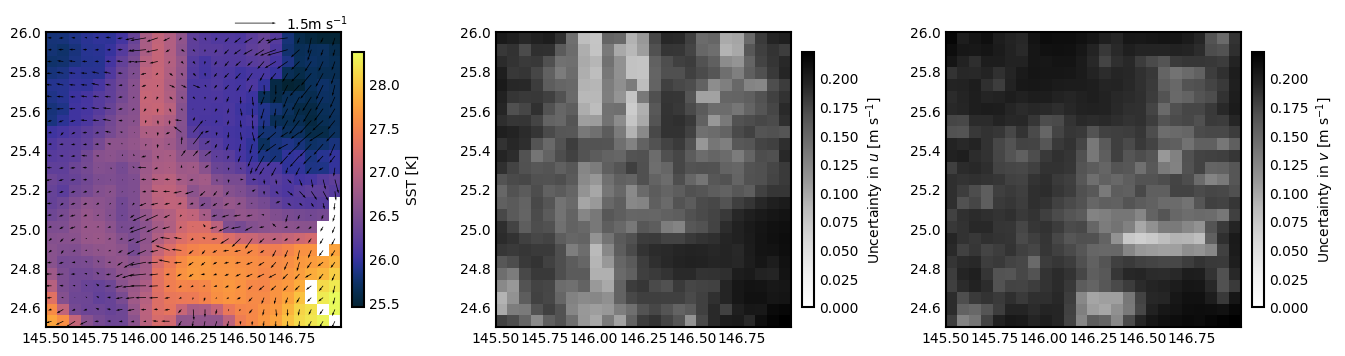

In [15]:
fig, ax = plots.plot_prediction(ds_all.isel(time=14), qk_size=1.5)

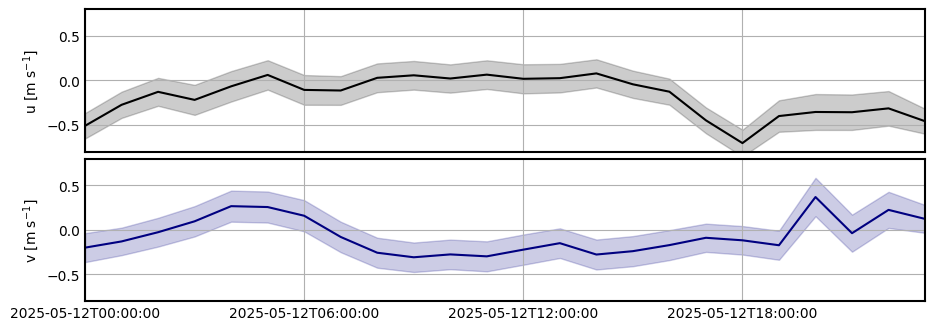

In [17]:
fig, ax = plots.plot_timeseries(ds_step, lon_pt=146.5, lat_pt=25.5, xl_thin=6)

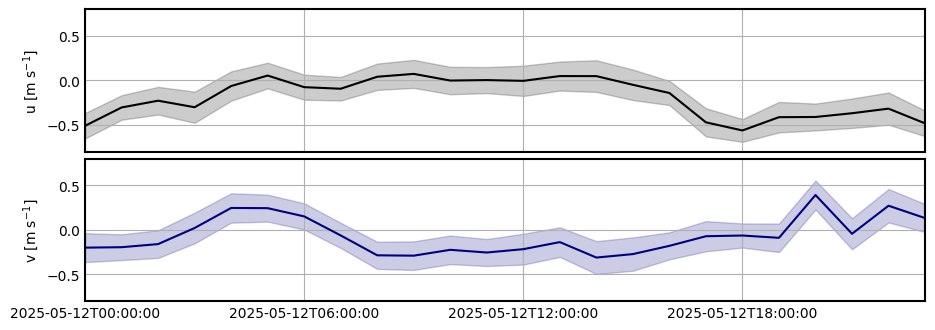

In [18]:
fig, ax = plots.plot_timeseries(ds_all, lon_pt=146.5, lat_pt=25.5, xl_thin=6)

In [64]:
from IPython.display import HTML
%matplotlib notebook

ani = plot_prediction_animation(ds, qk_size=1.5)
HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>